__Example 7.16.__ The boundary value problem

$$ \frac{d^2 T_s}{d x^2} = \frac{2(a+b)}{ab} \frac{h}{k} \left[ T_s(x) - T_{\text{amb}}\right] $$
$$ \frac{dT_s}{dx}(0) = -\frac{\Phi}{k}\,, \quad \frac{dT_s}{dx}(L) = \frac{h}{k}\left[ T_{\text{amb}} - T_s(L) \right] $$

models the steady state temperature of an uninsulated rod with souce heat $\Phi$ at $x=0$  and ambient air temperature $T_{\text{amb}}$. 

The model paramters to be estimated are $q = \left[ \Phi , h\right]$, where $h$ is the convective heat transfer coefficient.

In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy import *
import numpy as np

In [131]:
a = 0.95 #cm
b = 0.95 #cm
L = 70 #cm
k = 2.37 #W/cm/C
T_amb = 21.29 #C
x_obs = linspace(10,66,15)
T_obs = np.array([96.14,80.12,67.66,57.96,50.90,44.84,39.75,36.16,
                 33.31,31.15,29.28,27.88,27.18,26.40,25.86])
n = x_obs.size

Text(0,0.5,'T_obs (deg C)')

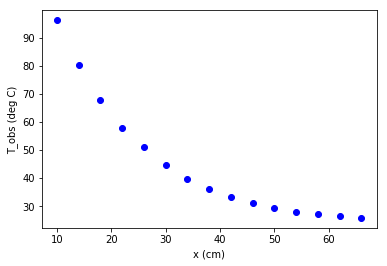

In [132]:
fig, ax  = plt.subplots()
ax.plot(x_obs, T_obs,'bo');
plt.xlabel('x (cm)')
plt.ylabel('T_obs (deg C)')

The solution is is 

$$ y_i(q) = T_s(x_i,q) = 
    c_1(q) e^{-\gamma x_i} + c_2(q) e^{\gamma x_i} + T_{\text{amb}} \,.$$
   
   where
   $ \gamma = \sqrt{\dfrac{2(a+b)h}{abk}}$ and
   
   $$c_1(q) = -\frac{\Phi}{k\gamma} \left[ \frac{(h+k\gamma) e^{\gamma L}}{(h-k\gamma) e^{-\gamma L} + (h+k\gamma) e^{\gamma L}}\right]\,, \quad c_2(q) = \frac{\Phi}{k\gamma} + c_1(q)\,.$$

In [133]:
def T(x,Phi,h):
    gamma = sqrt(2*(a+b)*h/a/b/k)
    f1 = (h+k*gamma)*exp(gamma*L)
    f2 = (h-k*gamma)*exp(-gamma*L)
    
    c1 = -Phi/k/gamma*( f1/(f1+f2) )
    c2 = Phi/k/gamma+c1
    return c1*exp(-gamma*x) + c2*exp(gamma*x) + T_amb

In [134]:
def SSE(q):
    Phi, h = q
    return sum((T(x_obs,Phi,h) - T_obs)**2)

In [135]:
from scipy import optimize
q_init = array([-18.4,0.01])
q_OLS=optimize.fmin(SSE,q_init)
Phi, h = q_OLS
Phi, h

Optimization terminated successfully.
         Current function value: 0.747088
         Iterations: 55
         Function evaluations: 108


(-18.4148856490254, 0.0019143246539385923)

Text(0,0.5,'Residuals (deg C)')

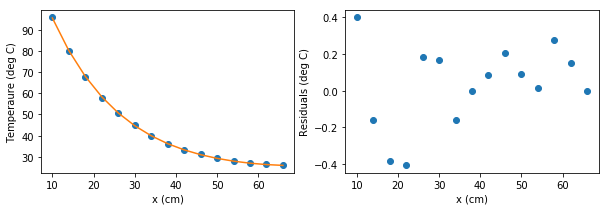

In [136]:
fig, (ax1, ax2)  = plt.subplots(1,2,figsize=(10,3))
ax1.plot(x_obs, T_obs,'o');
ax1.plot(x_obs, T(x_obs,Phi,h))
ax1.set_xlabel('x (cm)')
ax1.set_ylabel('Temperaure (deg C)')
ax2.plot(x_obs, T_obs - T(x_obs,Phi,h),'o')
ax2.set_xlabel('x (cm)')
ax2.set_ylabel('Residuals (deg C)')

In [137]:
sigma = np.std(T_obs - T(x_obs,q_OLS[0],q_OLS[1]),ddof=2)
sigma = sqrt(sum( (T_obs - T(x_obs,q_OLS[0],q_OLS[1]))**2 )/(n-2))
sigma**2

0.05746829372054907

($\sigma^2$ does not agree with text.)

Compute sensativity matrix by finite differences.

In [138]:
dh = 1e-10
dPhi = 1e-4
dTdh = (T(x_obs,Phi,h+dh) - T(x_obs,Phi,h))/dh
dTdPhi = (T(x_obs,Phi+dPhi,h) - T(x_obs,Phi,h))/dPhi

In [139]:
Chi = np.transpose([dTdPhi,dTdh])

In [140]:
shape(Chi)

(15, 2)

In [141]:
XtX = np.dot(np.transpose(Chi),Chi)

In [142]:
Vfd = sigma**2*np.linalg.inv(XtX)
Vfd

array([[ 1.93899945e-02, -1.87351809e-06],
       [-1.87351809e-06,  1.94042365e-10]])

In [143]:
sqrt(Vfd[0,0]),sqrt(Vfd[1,1])

(0.13924796059739097, 1.3929908998390829e-05)

$\sigma_\Phi$ and $\sigma_h$

95% confidence intervals

In [144]:
Phi+sigma*sqrt(Vfd[0,0])*np.array([-1,1])

array([-18.44826693, -18.38150437])

In [145]:
from scipy import stats
alpha = 0.05
stats.t.ppf(1-alpha/2,df=n-2)

2.1603686564610127

In [146]:
Phi + sqrt(Vfd[0,0])*np.array([-1,1])*stats.t.ppf(0.025,df=n-2)

array([-18.11405872, -18.71571258])

In [147]:
h+sqrt(Vfd[1,1])*np.array([-1,1])*stats.t.ppf(0.025,df=n-2)

array([0.00194442, 0.00188423])